# Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
ENCODER_LEN = 100
DECODER_LEN = 100
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*4

# Dataset

I have filtered and removed sentences that contain very few characters or several of them to inprove model performance.
Sentences in both english and hindi are then tokenized and padded to fix length

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Hindi_English_Truncated_Corpus.csv")
train_df.drop(['source'],axis=1,inplace=True)
mask = (train_df['english_sentence'].str.len()>20) & (train_df['english_sentence'].str.len()<200)
train_df = train_df.loc[mask]
train_df = train_df.sample(64000, random_state=1)
train_df.head()

,english_sentence,hindi_sentence
63241,Indian News Service - National News Agency,इण्डियन न्यूज सर्विस - राष्ट्रीय समाचार एजेंसी
81404,"In West Bengal , it seems set to eat humble pi...",पश्चिम बंगाल में तो वह अपमान का घूंट पीने को भ...
8803,One american dollar is equal to 60 pakistani r...,एक अमरीकी डालर की कीमत लगभग ६० पाकिस्तानी रुपय...
73434,"but between those high highs,",लेकिन इन बेहतरीन लम्हों के बीच
65711,Every other politician went along because when...,और वजह यह थी कि आर्थिक मामलं पर हमेशा विफल विच...


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df.shape

(64000, 2)

In [ ]:
# Compute word counts for English and Hindi columns
train_df['english_word_count'] = train_df['english_sentence'].apply(lambda x: len(str(x).split()))
train_df['hindi_word_count'] = train_df['hindi_sentence'].apply(lambda x: len(str(x).split()))

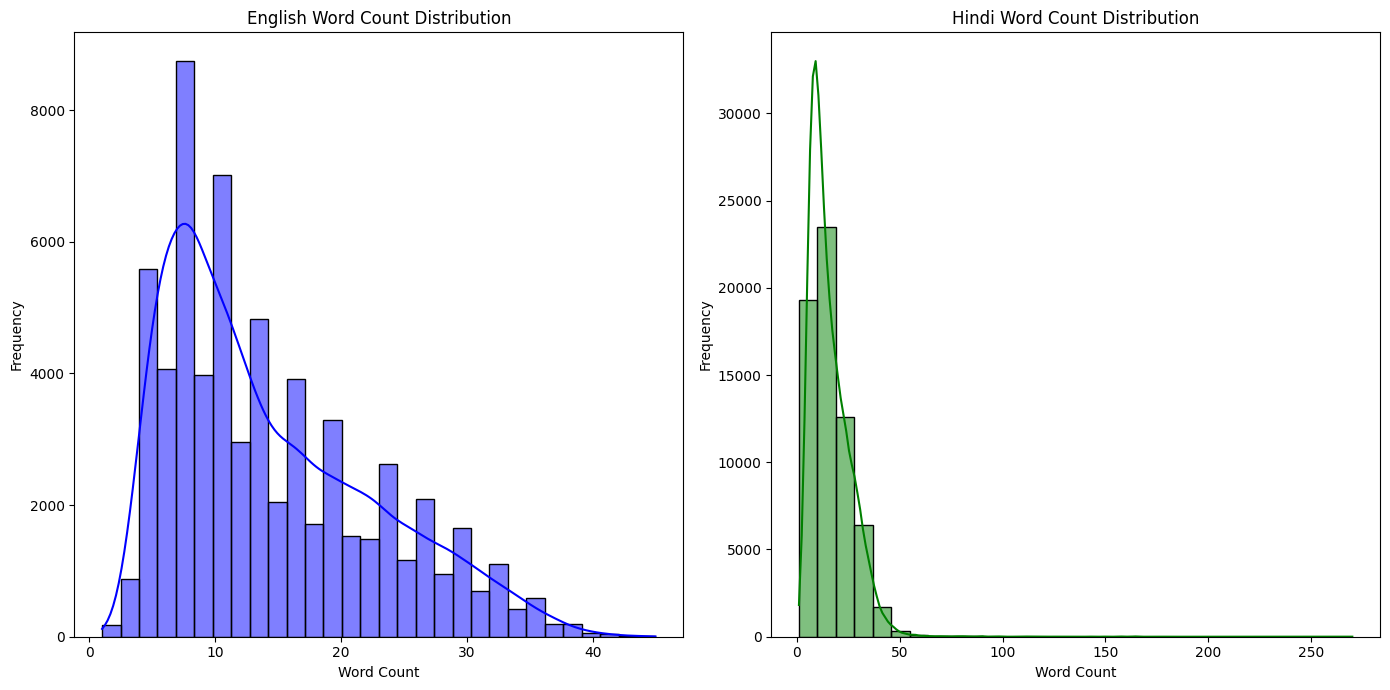

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting area
plt.figure(figsize=(14, 7))

# Plot word count distribution for English
plt.subplot(1, 2, 1)
sns.histplot(train_df['english_word_count'], bins=30, kde=True, color='blue')
plt.title('English Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot word count distribution for Hindi
plt.subplot(1, 2, 2)
sns.histplot(train_df['hindi_word_count'], bins=30, kde=True, color='green')
plt.title('Hindi Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
hind = new_train['hindi_sentence']
eng = new_train['english_sentence']
hind = hind.apply(lambda x: "<SOS> " + x + " <EOS>")
eng = eng.apply(lambda x: "<SOS> "+ str(x) + " <EOS>")

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng)
hind_tokenizer.fit_on_texts(hind)
inputs = hind_tokenizer.texts_to_sequences(hind)
targets = eng_tokenizer.texts_to_sequences(eng)

In [ ]:
ENCODER_VOCAB = len(hind_tokenizer.word_index) + 1
DECODER_VOCAB = len(eng_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

11646 9866


In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 400

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Custom Loss and Accuracy

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Training the Model

In [ ]:
train_loss_history = []
train_accuracy_history = []

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

        if batch % 200 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

    train_loss_history.append(train_loss.result())
    train_accuracy_history.append(train_accuracy.result())

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.1939 Accuracy 0.0000
Epoch 1 Loss 7.8356 Accuracy 0.0719
Time taken for 1 epoch: 57.32805800437927 secs

Epoch 2 Batch 0 Loss 6.7895 Accuracy 0.0722
Epoch 2 Loss 6.8233 Accuracy 0.0871
Time taken for 1 epoch: 13.971637487411499 secs

Epoch 3 Batch 0 Loss 6.8715 Accuracy 0.0873
Epoch 3 Loss 6.7249 Accuracy 0.0954
Time taken for 1 epoch: 11.546861171722412 secs

Epoch 4 Batch 0 Loss 6.5585 Accuracy 0.0956
Epoch 4 Loss 6.5769 Accuracy 0.1021
Time taken for 1 epoch: 10.426592826843262 secs

Epoch 5 Batch 0 Loss 6.5761 Accuracy 0.1022
Saving checkpoint for epoch 5 at checkpoints/ckpt-1
Epoch 5 Loss 6.3739 Accuracy 0.1083
Time taken for 1 epoch: 10.441958904266357 secs

Epoch 6 Batch 0 Loss 6.3560 Accuracy 0.1084
Epoch 6 Loss 6.1866 Accuracy 0.1142
Time taken for 1 epoch: 8.769124269485474 secs

Epoch 7 Batch 0 Loss 5.8692 Accuracy 0.1143
Epoch 7 Loss 6.0249 Accuracy 0.1197
Time taken for 1 epoch: 8.868197917938232 secs

Epoch 8 Batch 0 Loss 5.9452 Accuracy 0.1197
Epoc

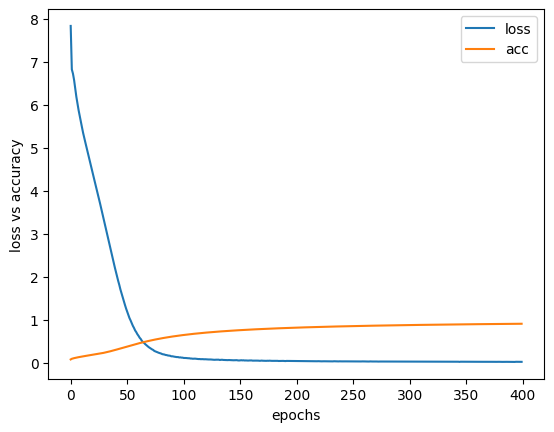

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history,label='loss')
plt.plot(train_accuracy_history,label='acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss vs accuracy')
plt.show()

In [ ]:
def evaluate(text):
    text = hind_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=ENCODER_LEN,
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [eng_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input,
            output,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == eng_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(hind_text):
    eng_text = evaluate(text=hind_text)[0].numpy()
    eng_text = np.expand_dims(eng_text[1:], 0)
    return eng_tokenizer.sequences_to_texts(eng_text)[0]

# Predictions


In [ ]:
model.translate("आप कैसे हैं")

'How are you'

In [ ]:
r1 = model.translate('यह हमारा अंतिम वर्ष का प्रोजेक्ट है')
r1

'this is our final year project'

In [ ]:
model.translate('एंड्राइड फोन यूजर्स के लिए अच्छी खबर है')

'Good news for Android phone users'

In [ ]:
model.translate('यह प्रोजेक्ट ओम और देवांश द्वारा बनाया गया है')

'This project is created by Om and Devansh'

In [ ]:
model.translate('मैं यह करूंगा')

'I will do this'

In [ ]:
model.translate('यह एक अच्छी शाम है')

"It's a nice evening"

In [ ]:
actual = np.array(['यह एक अच्छी शाम है','मैं यह करूंगा','यह प्रोजेक्ट ओम और देवांश द्वारा बनाया गया है','एंड्राइड फोन यूजर्स के लिए अच्छी खबर है',
                   'यह हमारा अंतिम वर्ष का प्रोजेक्ट है',"आप कैसे हैं",'इण्डियन न्यूज सर्विस','बेहतरीन लम्हों के बीच',
                   'एक अमरीकी डालर की कीमत लगभग ६० पाकिस्तानी रुपय','हिंदी दुनिया की चौथी सबसे अधिक बोली जाने वाली पहली भाषा है',
                   'मानक हिंदी दिल्ली की बोली पर आधारित है','स्वतंत्रता के बाद',' भारत की संविधान सभा',' देवनागरी','प्रयोग','रूप','अंतर्राष्ट्रीय',
                   'प्रारंभ','अतिरिक्त','भाषाओं का उपयोग','सरकारें',' निर्देशों के अनुसार','अधिक आबादी','सामाजिक महत्व','उपराष्ट्रपति'])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_tokens = []
target_tokens = []

# Iterate over the validation dataset
for inp in actual:
    prediction = model.translate(inp)  # Your method to get the model prediction
    # Flatten the lists and extend the predicted and target tokens
    predicted_tokens.extend(prediction)

In [ ]:
pred = eng_tokenizer.texts_to_sequences(predicted_tokens)

In [ ]:
import numpy as np
from indicnlp.tokenize import indic_tokenize

actual_word_tokens = [indic_tokenize.trivial_tokenize(sentence) for sentence in actual]

# Flatten the list of lists to get a single list of word tokens
actual_word_tokens_flat = [word for sentence in actual_word_tokens for word in sentence]

# Print the tokenized words
print(actual_word_tokens_flat)

['यह', 'एक', 'अच्छी', 'शाम', 'है', 'मैं', 'यह', 'करूंगा', 'यह', 'प्रोजेक्ट', 'ओम', 'और', 'देवांश', 'द्वारा', 'बनाया', 'गया', 'है', 'एंड्राइड', 'फोन', 'यूजर्स', 'के', 'लिए', 'अच्छी', 'खबर', 'है', 'यह', 'हमारा', 'अंतिम', 'वर्ष', 'का', 'प्रोजेक्ट', 'है', 'आप', 'कैसे', 'हैं', 'इण्डियन', 'न्यूज', 'सर्विस', 'बेहतरीन', 'लम्हों', 'के', 'बीच', 'एक', 'अमरीकी', 'डालर', 'की', 'कीमत', 'लगभग', '६०', 'पाकिस्तानी', 'रुपय', 'हिंदी', 'दुनिया', 'की', 'चौथी', 'सबसे', 'अधिक', 'बोली', 'जाने', 'वाली', 'पहली', 'भाषा', 'है', 'मानक', 'हिंदी', 'दिल्ली', 'की', 'बोली', 'पर', 'आधारित', 'है', 'स्वतंत्रता', 'के', 'बाद', 'भारत', 'की', 'संविधान', 'सभा', 'देवनागरी', 'प्रयोग', 'रूप', 'अंतर्राष्ट्रीय', 'प्रारंभ', 'अतिरिक्त', 'भाषाओं', 'का', 'उपयोग', 'सरकारें', 'निर्देशों', 'के', 'अनुसार', 'अधिक', 'आबादी', 'सामाजिक', 'महत्व', 'उपराष्ट्रपति']


In [ ]:
act = hind_tokenizer.texts_to_sequences(actual_word_tokens_flat)

In [ ]:
predicted_sentences = ['Its a nice evening', 'I will do this', 'This project is created by Om and Devansh',
                       'Good news for Android phone users', 'This is our final year project', 'How are you',
                       'Indian News Service', 'In between the best moments',
                       'One US dollar is worth approximately 60 Pakistani Rupees',
                       'Hindi is the fourth most widely spoken first language in the world',
                       'Standard Hindi is based on the Delhi dialect', 'After independence',
                       'Constituent Assembly of India', 'Devanagari', 'Usage', 'Form', 'International',
                       'Beginning', 'Additional', 'Use of languages', 'Governments',
                       'According to instructions', 'More population', 'Social importance', 'Vice President']

# Convert predicted sentences to word tokens
predicted_word_tokens = [sentence.split() for sentence in predicted_sentences]
predicted_word_tokens_flat = [word for sentence in predicted_word_tokens for word in sentence]

In [ ]:
act_predicted_word_tokens = [sentence.split() for sentence in predicted_sentences]
act_predicted_word_tokens_flat = [word for sentence in predicted_word_tokens for word in sentence]

In [ ]:
pre = eng_tokenizer.texts_to_sequences(predicted_word_tokens_flat)

<Figure size 40000x40000 with 0 Axes>

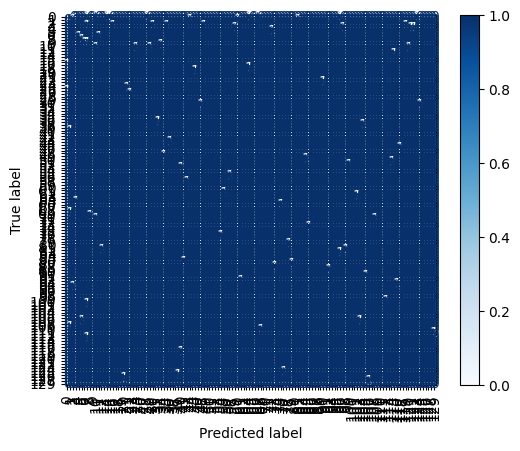

In [ ]:
conf_matrix = confusion_matrix(act[:93], pre)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(400,400))  # Adjust figure size for readability
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()

***BLEU SCORE***

In [ ]:
smoothing_function = SmoothingFunction().method1
bleu_scores = [sentence_bleu([ref], pred, smoothing_function=smoothing_function)
               for ref, pred in zip(act_predicted_word_tokens, predicted_word_tokens)]

In [ ]:
bleu_scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5623413251903491,
 0.5623413251903491,
 1.0,
 1.0,
 1.0,
 1.0,
 0.316227766016838,
 1.0,
 0.1778279410038923,
 0.1778279410038923,
 0.1778279410038923,
 0.1778279410038923,
 0.1778279410038923,
 0.1778279410038923,
 0.5623413251903491,
 0.1778279410038923,
 0.5623413251903491,
 0.316227766016838,
 0.316227766016838,
 0.316227766016838]